# Flight Tracking Project
By: Tair Schapira, May Ogen

In [81]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# -------- classification
import sklearn
from sklearn import neighbors, tree, ensemble, naive_bayes, svm
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

# Crawling
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from datetime import date, timedelta
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
import traceback
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException
from datetime import date, timedelta, datetime
from random import randint, random
import itertools
import re
import os

MIN_PRICE = 100
MAX_PRICE = 750
MIN_FLIGHT_DURATION = 2
MAX_FLIGHT_DURATION = 19

# Crawling

In [139]:
def click_checkbox_by_name(driver, checkbox_name):
    SLEEP_TIME = 0.1
    total_time_to_wait = 20
    close_cookies_popup(driver)
    while total_time_to_wait > 0:
        try:
            driver.find_element(By.NAME, checkbox_name).click()
        except (NoSuchElementException, ElementClickInterceptedException) as e:
            time.sleep(SLEEP_TIME)
            total_time_to_wait -= SLEEP_TIME
            continue
        break

def close_cookies_popup(driver):
    grand_parent_element = driver.find_elements(By.CLASS_NAME, "osano-cm-window")[0]
    for parent_element in grand_parent_element.find_elements(By.XPATH, ".//*"):
        if parent_element.accessible_name == "Cookie Consent Banner":
            for element in parent_element.find_elements(By.XPATH, ".//*"):
                if element.aria_role == "button":
                    element.click()
                    break

def choose_one_parameter_from_travel_baggage(driver):
    departure_time_of_day_options = {1: 'SEAT_CHOICE', 2: 'CARRY_ON_BAG', 3: 'NO_CANCEL_FEE', 4: 'FLEXIBLE_CHANGE_POLICIES'}
    departure_time_of_day_keys = list(departure_time_of_day_options.keys())
    while len(departure_time_of_day_keys) > 0:
        random_num = randint(0, len(departure_time_of_day_keys) - 1)
        depature_time_of_day_key = departure_time_of_day_keys[random_num]
        try:
            click_checkbox_by_name(driver, departure_time_of_day_options[depature_time_of_day_key])
            return departure_time_of_day_options[depature_time_of_day_key]
        except Exception:
            print("choose_one_parameter_from_travel_baggage didn't find {}, trying again".format(departure_time_of_day_options[depature_time_of_day_key]))
            departure_time_of_day_keys.pop(random_num)
    raise Exception("No travel baggage option exists")

def choose_departure_time_of_day(driver):
    departure_time_of_day_options = {1: 'Early morning', 2: 'Morning', 3: 'Afternoon', 4: 'Evening'}
    departure_time_of_day_keys = list(departure_time_of_day_options.keys())
    while len(departure_time_of_day_keys) > 0:
        random_num = randint(0, len(departure_time_of_day_keys) - 1)
        depature_time_of_day_key = departure_time_of_day_keys[random_num]
        try:
            driver.find_element(By.CSS_SELECTOR, '[aria-label*="{}"]'.format(departure_time_of_day_options[depature_time_of_day_key])).click()
            return departure_time_of_day_options[depature_time_of_day_key]
        except Exception:
            print("choose_departure_time_of_day didn't find {}, trying again".format(departure_time_of_day_options[depature_time_of_day_key]))
            departure_time_of_day_keys.pop(random_num)
    raise Exception("No departure time of day option exists")

def get_flight_connection_information(driver, cheapest_price):
    for flight in driver.find_elements(By.CLASS_NAME, "uitk-card-link"):
        flight_details = flight.find_element(By.XPATH, ".//*").text
        if str(cheapest_price) in flight_details:
            if "Direct" in flight_details:
                return "Direct"
            elif "One stop" in flight_details:
                return "One stop"
            elif "Two stops" in flight_details:
                return "Two stops"
    raise Exception("Unexpected, layover strings were not found for price {}".format(cheapest_price))
    
def maybe_choose_direct_flight_and_wait(driver):
    random_num = randint(1,3)
    if random_num == 1:
        # Direct should show up in the first 5 labels
        labels = driver.find_elements(By.CLASS_NAME, "uitk-checkbox-label-content")[:5]
        for label in labels:
            if "Direct" in label.text:
                time.sleep(1)
                label.click()
                time.sleep(5)
                return

def get_flight_duration_string(driver, cheapest_price):
    for flight in driver.find_elements(By.CLASS_NAME, "uitk-card-link"):
        flight_details = flight.find_element(By.XPATH, ".//*").text
        if str(cheapest_price) in flight_details:
            comma_segments = flight_details.split(',')
            for comma_segment in comma_segments:
                period_segments = comma_segment.split('.')
                for period_segment in period_segments:
                    if "travel time" in period_segment:                        
                        return period_segment

def get_airline_from_text(driver, cheapest_price):
    for flight in driver.find_elements(By.CLASS_NAME, "uitk-card-link"):
        flight_details = flight.find_element(By.XPATH, ".//*").text
        if str(cheapest_price) in flight_details:
            match = re.search(r"for (.*?) flight", flight_details)
            if match:
                airline = match.group(1)
                return airline                    
                    
def get_travel_time_from_text(driver, cheapest_price):
    text = get_flight_duration_string(driver, cheapest_price)
    hours_match = re.search(r'(\d+)\s*hours', text)
    minutes_match = re.search(r'(\d+)\s*minutes', text)
    hours = int(hours_match.group(1)) if hours_match else 0
    minutes = int(minutes_match.group(1)) if minutes_match else 0
    total_hours = hours + (minutes / 60)
    rounded_hours = round(total_hours, 2)
    return rounded_hours        

def get_flight_cheapest_price(dest_country, start_date, end_date):
    driver = webdriver.Chrome()
    driver.get("https://euro.expedia.net/")
    link_element = driver.find_element(By.XPATH, "//a[span[text()='Flights']]").click()
    # 20 seconds timeout for elements to load
    wait = WebDriverWait(driver, 20)
    
    # Filling "Leaving from"
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '[aria-label="Leaving from"]'))).click()
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'input[placeholder*="leaving from" i]'))).click()
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'input[placeholder*="leaving from" i]'))).send_keys("Tel Aviv (TLV - Ben Gurion) Israel")
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '[aria-label="Tel Aviv (TLV - Ben Gurion) Israel"]'))).click()
    time.sleep(5)
    
    # Filling "Going to"
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '[aria-label="Going to"]'))).click()
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'input[placeholder*="going to" i]'))).click()
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'input[placeholder*="going to" i]'))).send_keys(dest_country)
    css_selector = "[aria-label='{}']".format(dest_country)
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR,css_selector))).click() 

    
    # Filling "Departure Date" and "Arrival Date"
    try:
        formatted_departure_details = f"from:Tel Aviv (TLV - Ben Gurion) Israel,to:{dest_country},departure:{start_date.day}/{start_date.month}/{start_date.year}TANYT"
        formatted_arrival_details = f"from:Tel Aviv (TLV - Ben Gurion) Israel,to:{dest_country},departure:{end_date.day}/{end_date.month}/{end_date.year}TANYT"
        driver.execute_script(f"arguments[0].setAttribute('value', '{formatted_departure_details}')", driver.find_element(By.CSS_SELECTOR, '[data-testid="flight-leg1"]'))
        driver.execute_script(f"arguments[0].setAttribute('value', '{formatted_arrival_details}')", driver.find_element(By.CSS_SELECTOR, '[data-testid="flight-leg2"]'))
        # Click the submit button
        wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '[data-testid="submit-button"]'))).click()
    except Exception:
        formatted_departure_details = start_date.strftime("%Y-%m-%d")
        formatted_arrival_details = end_date.strftime("%Y-%m-%d")
        driver.execute_script(f"arguments[0].setAttribute('value', '{formatted_departure_details}')", driver.find_element(By.NAME, "EGDSDateRangePicker-StartDate-date_form_field"))
        driver.execute_script(f"arguments[0].setAttribute('value', '{formatted_arrival_details}')", driver.find_element(By.NAME, "EGDSDateRangePicker-EndDate-date_form_field"))
        # Click the submit button
        wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '[aria-label="Search"]'))).click()
    
    # Enlarge the page
    driver.maximize_window()
    #Filtered Selections
    travel_option_selected = choose_one_parameter_from_travel_baggage(driver)
    departure_time_of_day= choose_departure_time_of_day(driver)
    
    #after the page has loaded - choose the direct flight if it exists after filters
    time.sleep(5)
    maybe_choose_direct_flight_and_wait(driver)
    
    #Find price of the cheapest flight
    cheapest_price = wait.until(EC.visibility_of_element_located((By.CLASS_NAME, 'uitk-lockup-price'))).text
    currency = cheapest_price[0]
    if currency != "€":
        raise Exception("Expected Euro Currency Symbol, but got currency:{}".format(currency))
    cheapest_price = cheapest_price[1:] # Trim the currency from the price
    
    #the flight's details were loaded successfully
    flight_connection = get_flight_connection_information(driver, cheapest_price)
    flight_duration = get_travel_time_from_text(driver, cheapest_price)
    airline = get_airline_from_text(driver, cheapest_price)
    
    cheapest_price_without_comma = cheapest_price.replace(',', '')
    return int(cheapest_price_without_comma), travel_option_selected, departure_time_of_day, flight_connection, flight_duration, airline

def get_random_airport():
    dest_airports = ['Paris (PAR - All Airports) France', 'Rome (ROM - All Airports) Italy', 'Barcelona (BCN - Barcelona Intl.) Spain', 
                     'Madrid (MAD - All Airports) Spain', 'Frankfurt (FRA - All Airports) Germany', 'Athens (ATH - Eleftherios Venizelos) Greece', 
                     'London (LON - All Airports) United Kingdom', 'Amsterdam (AMS - All Airports) Netherlands', 'Budapest (BUD - Ferenc Liszt Intl.) Hungary',
                     'Zürich (ZRH - Zürich) Switzerland', 'Bucharest (OTP - Henri Coanda Intl.) Romania', 'Lisbon (LIS - Humberto Delgado) Portugal']
    num_of_airports = len(dest_airports)
    index = randint(0,num_of_airports-1)
    return dest_airports[index]

def get_trip_duration(number_of_days):
    if number_of_days >= 3 and number_of_days <= 4:
        return "Short"
    if number_of_days >= 5 and number_of_days <= 10:
        return "Medium"
    if number_of_days >= 11 and number_of_days <= 21:
        return "Long"
    raise Exception("Unexpected number of trip days")

def get_random_trip_durations():
    short_trip_duration = randint(3,4)
    medium_trip_duration = randint(5,10)
    long_trip_duration = randint(11,21)
    return [short_trip_duration, medium_trip_duration, long_trip_duration]
    
def get_random_trip_date(trip_duration):
    start = datetime.now()+timedelta(1) #starting from tomorrows date
    """
    1 - since we start with tomorrow's date
    31 - since there are only flights 11 months ahead in Expedia
    duration - number of days of the trip 
    """
    end = start + timedelta(days = 365 - 1 - 31 - trip_duration)
  
    max_delta_days = (end - start).days

    # Get the start and end dates of the flight
    departure_date = start + timedelta(days = randint(0, max_delta_days))
    return_date = departure_date + timedelta(days = trip_duration)

    return departure_date, return_date

#function receives the departure_date and returns what season of the year that is as a string
def get_season(departure_date):
    spring_start = datetime(departure_date.year, 3, 21)
    summer_start = datetime(departure_date.year, 6, 21)
    autumn_start = datetime(departure_date.year, 9, 23)
    winter_start = datetime(departure_date.year, 12, 21)
    if departure_date >= spring_start and departure_date < summer_start:
        return 'Spring'
    elif departure_date >= summer_start and departure_date < autumn_start:
        return 'Summer'
    elif departure_date >= autumn_start and departure_date < winter_start:
        return 'Autumn'        
    else:
        return 'Winter' 

# function that receives departure and return dates and returns whether the trip falls on entire holiday or not
def is_trip_during_holiday(departure_date, return_date):
    start_rosh_hashana = datetime(2023, 9, 15)
    end_rosh_hashana = datetime(2023, 9, 17)
    start_yom_kippur = datetime(2023, 9, 24)
    end_yom_kippur = datetime(2023, 9, 25) 
    start_sukkot = datetime(2023, 9, 29)
    end_sukkot = datetime(2023, 10, 7) 
    start_hannukah = datetime(2023, 12, 8)
    end_hannukah = datetime(2023, 12, 15) 
    start_passover = datetime(2023, 4, 22)
    end_passover = datetime(2023, 4, 29)
    
    holidays = [start_rosh_hashana, end_rosh_hashana, 
               start_yom_kippur, end_yom_kippur, 
               start_sukkot, end_sukkot, 
               start_hannukah, end_hannukah, 
               start_passover, end_passover]
    
    for i in range(0, len(holidays), 2):
        start_date = holidays[i]
        end_date = holidays[i+1]
        if departure_date <= start_date and return_date >= end_date:
            return True
    return False
        
def get_date_combinations():
    trip_durations = get_random_trip_durations()
    trip_dates = []
    for trip_duration in trip_durations:
        start_date_trip, end_date_trip = get_random_trip_date(trip_duration)
        dates_dict = {"departure_date":start_date_trip, "return_date":end_date_trip} #dictionary of start and end dates
        trip_dates.append(dates_dict) #list of dictionarys
    return trip_dates

def get_all_combinations_per_airport():
    # Here we can add more combinations per attribute (for instance, layover combinations)
    date_combinations = get_date_combinations()

    random_airport = [get_random_airport()]
    return list(itertools.product(date_combinations,random_airport))

def get_number_of_combinations_per_airport():
    all_combinations_per_airport = get_all_combinations_per_airport()
    return len(all_combinations_per_airport)

def get_file_path_including_today_date(file_path):
    # Split the file path into directory and file name
    directory, filename = os.path.split(file_path)
    # Get the current date and time
    current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # Append the current date and time to the file name
    new_filename = f"{os.path.splitext(filename)[0]}-{current_datetime}{os.path.splitext(filename)[1]}"
    # Join the directory and new file name
    new_file_path = os.path.join(directory, new_filename)
    return new_file_path


def append_df_to_file(file_path, dataframe, is_new_run):
    if not hasattr(append_df_to_file, "start_row") or is_new_run:
        append_df_to_file.start_row = 0
    if append_df_to_file.start_row == 0:
        # Create a new file and write the df to it
        with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
            print("-----------Creating new xsls file-----------")
            dataframe.to_excel(writer, index=False)
            append_df_to_file.start_row += len(dataframe) + 1
    else:
        # Append df to an existing file
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='ab', if_sheet_exists='overlay') as writer:
            print("-----------Appending a new xlsx file to startrow={}-----------".format(append_df_to_file.start_row))
            dataframe.to_excel(writer, startrow=append_df_to_file.start_row, header=False, index=False) 
            append_df_to_file.start_row += len(dataframe)

def load_df_from_file(file_path):
    return pd.read_excel(file_path)


def create_data_frame():
    REQUIRED_NUMBER_OF_COMBINATIONS = 3 # Should be at least 50,000, for testing it should be relatively small number
    number_of_loop_iterations = int(REQUIRED_NUMBER_OF_COMBINATIONS / get_number_of_combinations_per_airport())
    list_of_all_combinations = []
    for iterations in range(number_of_loop_iterations):
        all_combinations_for_single_airport = get_all_combinations_per_airport()
        for combination in all_combinations_for_single_airport:
            list_of_all_combinations.append(combination)
    
    i = 1
    file_path = "Final_Project.xlsx"
    file_path = get_file_path_including_today_date(file_path)
    print("Writing dataframes to: {}".format(file_path))
    is_new_run = True
    df = pd.DataFrame(columns=['dest_airport', 'flight_duration', 'trip_duration', 'departure_day_of_week', 'departure_month',
                               'season', 'is_holiday', 'travel_option_selected', 'departure_time_of_day', 
                               'flight_connection', 'airline', 'cheapest_price'])
    for combination in list_of_all_combinations:
        try:
            departure_and_return_dates_dict = combination[0]
            departure_date = departure_and_return_dates_dict['departure_date']
            return_date = departure_and_return_dates_dict['return_date']
            departure_month = departure_date.month
            # 0 = Mon, 1 = Tues, 2 = Wed, 3 = Thurs, 4 = Fri, 5 = Sat, 6 - Sun
            day_of_the_week = departure_date.strftime("%A")
            is_holiday = is_trip_during_holiday(departure_date, return_date)
            season = get_season(departure_date)
            dest_airport = combination[1]
            
            print("Running get_flight_cheapest_price for the {} time (out of {})".format(i, len(list_of_all_combinations)))
            i += 1
            cheapest_price, travel_option_selected, departure_time_of_day, flight_connection, flight_duration, airline = get_flight_cheapest_price(dest_airport, departure_date, return_date)
            trip_duration = get_trip_duration((return_date-departure_date).days)
            df = df.append({'dest_airport': dest_airport, 'flight_duration': flight_duration, 'trip_duration' : trip_duration, 'departure_day_of_week': day_of_the_week, 'departure_month': departure_month, 'season': season, 
                            'is_holiday':is_holiday, 'travel_option_selected': travel_option_selected, 
                            'departure_time_of_day': departure_time_of_day, 'flight_connection': flight_connection, 
                            'airline': airline, 'cheapest_price': cheapest_price}, ignore_index=True)
            is_new_run = False
            # Make sure they don't block us
            time.sleep(randint(0, 5))
        except Exception:
            print(traceback.format_exc())
    time.sleep(4)
    df.to_excel(file_path, index=False)
    return df

dataframe = create_data_frame()


# Loading the data

In [82]:
#loading the excel file to a dataframe
def load_dataframe():
    file_path = "C:\\Users\\schap\\Desktop\\FlightsData\\combined_data_new.xlsx"
    df = pd.read_excel(file_path, header = 0)
    return df

df = load_dataframe()

# Cleaning the Data

In this section we will be cleaning the data. The duplicated rows were removed from the dataframe. We determined our outliers by the 'cheapest_price' column and the 'flight_duration' column. 

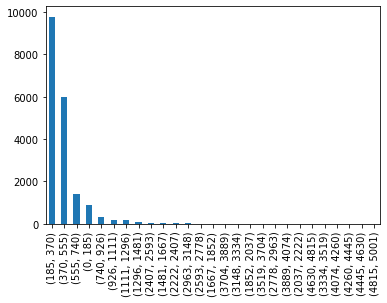

In [83]:
#Checking for outliers
def create_ranges(a, b, num_of_ranges):
    return [int(element) for element in np.linspace(a - 1, b + 1, num=num_of_ranges+1)]

def create_cheapest_price_plot(df):
    df = df.copy()
    price_ranges = create_ranges(1, 5000, 27)
    categories = [(price_ranges[i], price_ranges[i + 1]) for i in range(len(price_ranges) - 1)]
    df['cheapest_price'] = pd.cut(df['cheapest_price'], bins=price_ranges, labels=categories, right=False)
    df['cheapest_price'].value_counts().plot(kind='bar')
create_cheapest_price_plot(df)

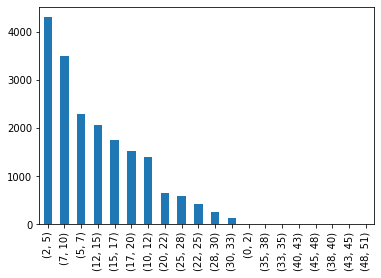

In [84]:
def create_flight_duration_plot(df):
    df = df.copy()
    duration_ranges = create_ranges(1, 50, 20)
    duration_categories = [(duration_ranges[i], duration_ranges[i + 1]) for i in range(len(duration_ranges) - 1)]
    df['flight_duration'] = pd.cut(df['flight_duration'], bins=duration_ranges, labels=duration_categories, right=False)
    df['flight_duration'].value_counts().plot(kind='bar')
create_flight_duration_plot(df)


In [85]:
#removing outliers from cheapest price and flight duration
#removes all duplicated rows

def remove_duplicate_rows_and_outliers(df):
    duplicate_rows = df.duplicated()
    num_duplicates = duplicate_rows.sum()
    if num_duplicates > 0:
        df.drop_duplicates(inplace=True)
    df = df[df['cheapest_price'] >= MIN_PRICE]
    df = df[df['cheapest_price'] <= MAX_PRICE]
    df = df[df['flight_duration'] >= MIN_FLIGHT_DURATION]
    df = df[df['flight_duration'] <= MAX_FLIGHT_DURATION]
    return df

def check_for_missing_data(df):
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        df = df.dropna(inplace=True)
    return df

df = load_dataframe()
df = remove_duplicate_rows_and_outliers(df)
df = check_for_missing_data(df)

# EDA/Visualization

This section will give us a visualization of how many flights there are per attribute. In addition, we compared each attribute to the cheapest price. This will show us if any one attribute possiblyt affected the flight price. 

In the departure month table, the month of May does not have many results because the crawling began at the end of May 2023 and expedia doesnt have many flight options past April 2024.

count    10956.000000
mean       381.746714
std        123.940663
min        106.000000
25%        294.000000
50%        365.000000
75%        461.000000
max        750.000000
Name: cheapest_price, dtype: float64


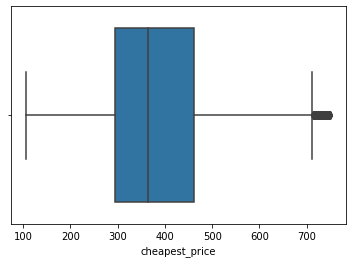

In [86]:
print(df['cheapest_price'].describe())
sns.boxplot(df['cheapest_price'])
plt.show()

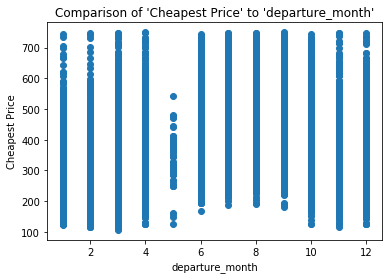

In [87]:
def print_eda_graphs(df, col_name):
    df[col_name].value_counts().plot(kind='bar')
    plt.title(f"How many flights per '{col_name}'")
    plt.show()
    
def compare_columns_plot(df, column_name):
    # Create the plot
    plt.scatter(df[column_name], df['cheapest_price'])
    plt.xlabel(column_name)
    plt.ylabel('Cheapest Price')
    plt.title(f"Comparison of 'Cheapest Price' to '{column_name}'")
    plt.show()
    
compare_columns_plot(df, 'departure_month')

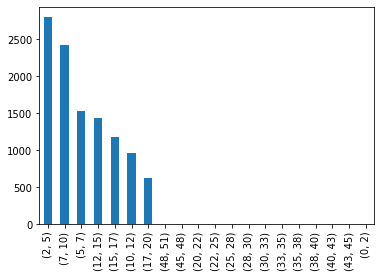

In [88]:
create_flight_duration_plot(df)

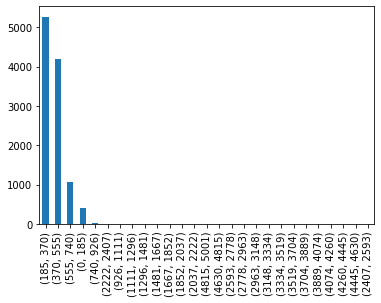

In [89]:
create_cheapest_price_plot(df)

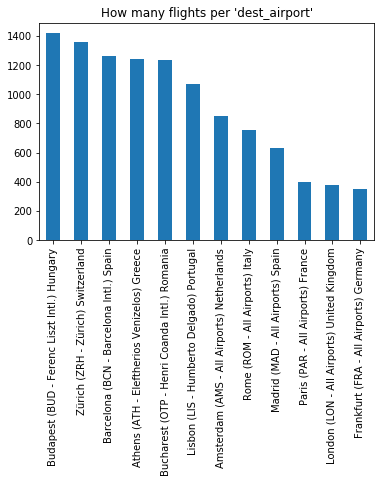

In [90]:
print_eda_graphs(df, 'dest_airport')

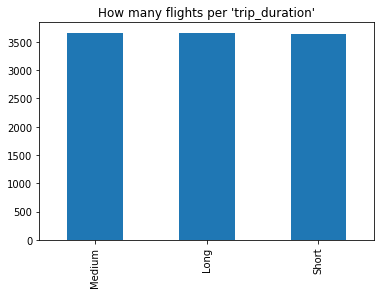

In [91]:
print_eda_graphs(df, 'trip_duration')

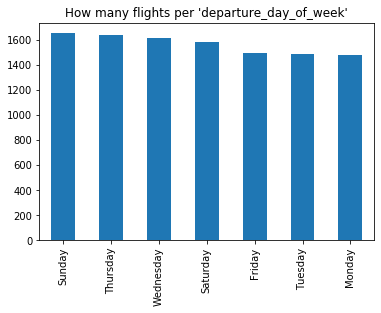

In [92]:
print_eda_graphs(df, 'departure_day_of_week')

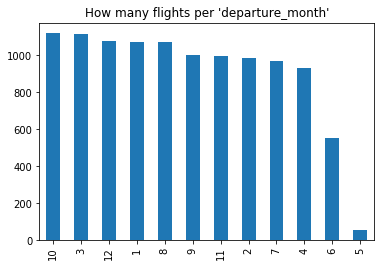

In [93]:
print_eda_graphs(df, 'departure_month')

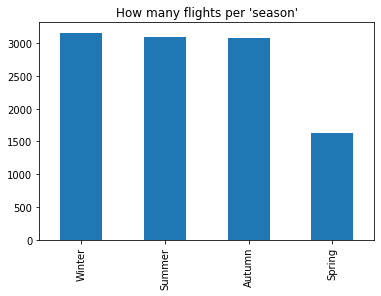

In [94]:
print_eda_graphs(df, 'season')

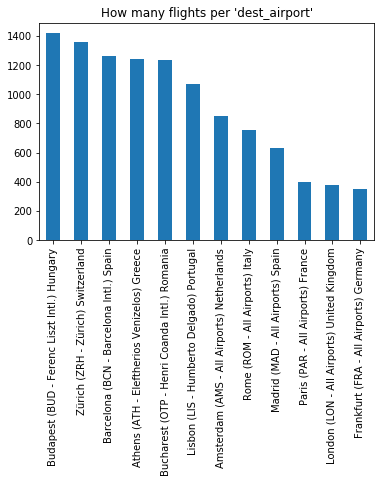

In [95]:
print_eda_graphs(df, 'dest_airport')

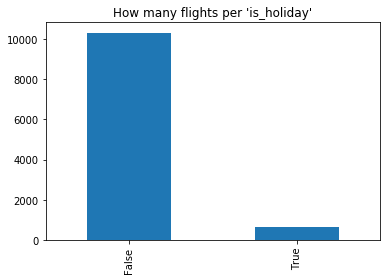

In [96]:
print_eda_graphs(df, 'is_holiday')

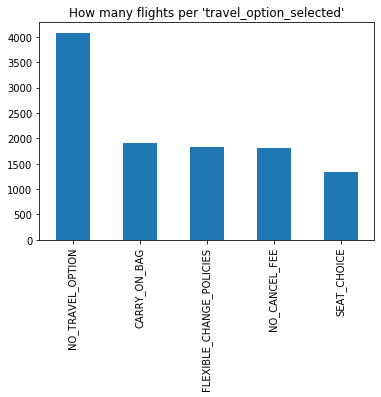

In [97]:
print_eda_graphs(df, 'travel_option_selected')

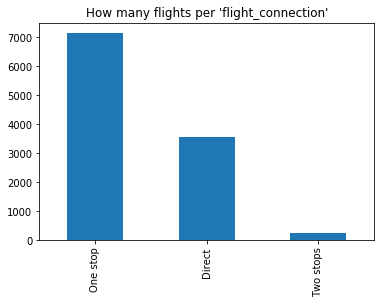

In [98]:
print_eda_graphs(df, 'flight_connection')

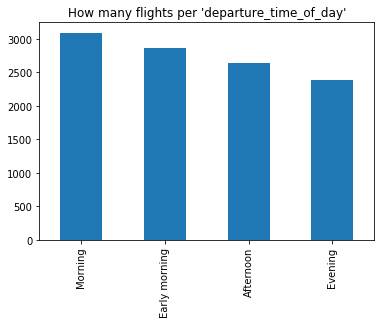

In [99]:
print_eda_graphs(df, 'departure_time_of_day')

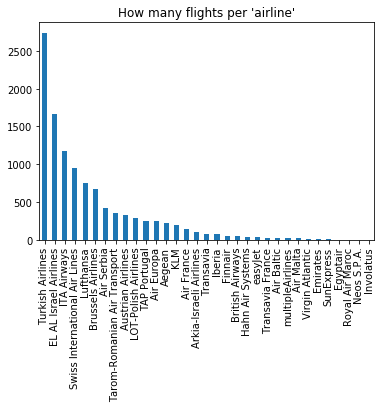

In [100]:
print_eda_graphs(df, 'airline')

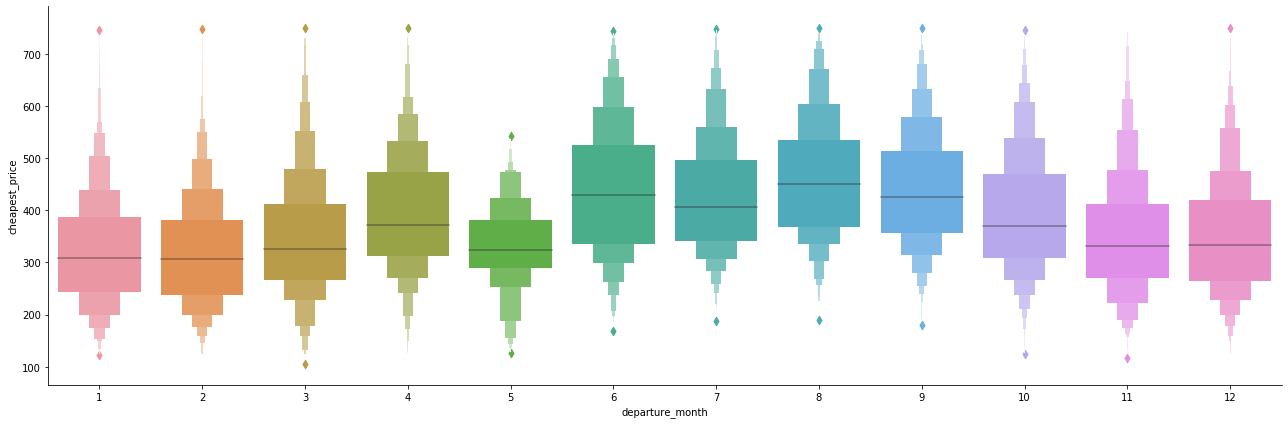

In [101]:
sns.catplot(y = "cheapest_price", x = "departure_month", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)

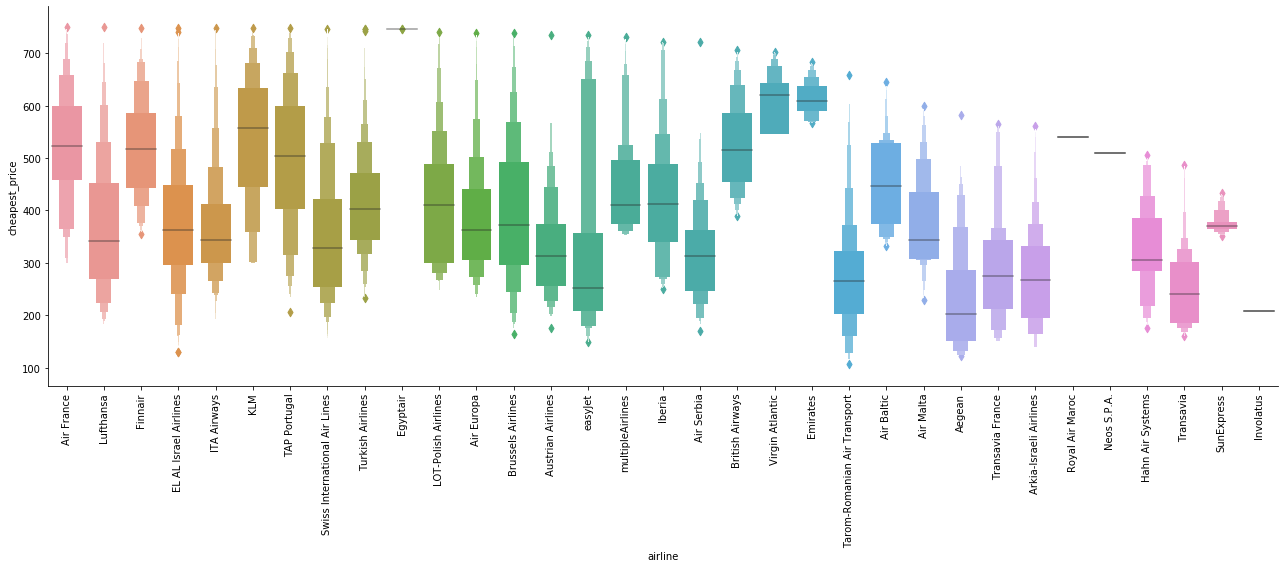

In [102]:
plot = sns.catplot(y = "cheapest_price", x = "airline", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)
plot.set_xticklabels(rotation=90)

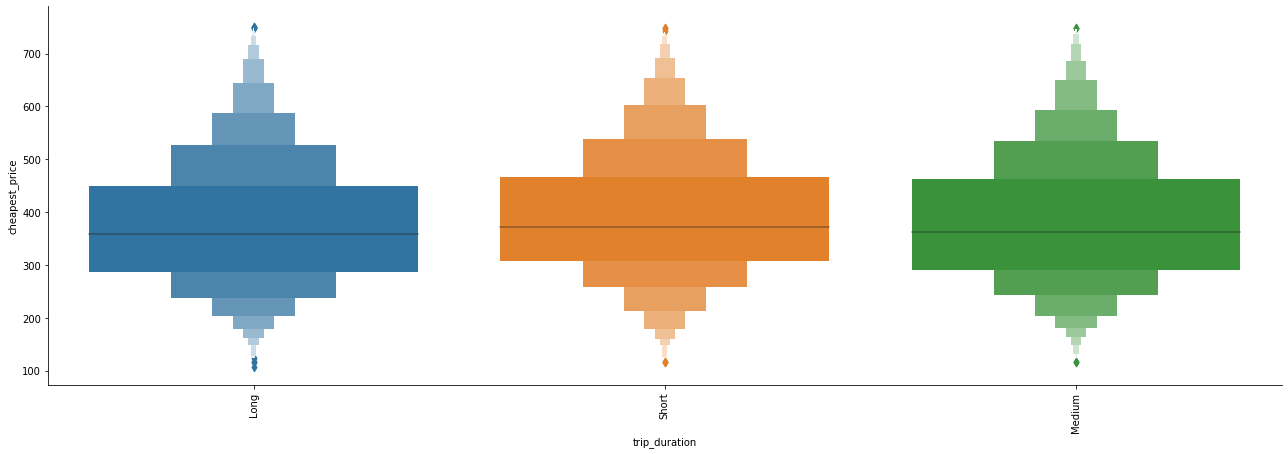

In [103]:
plot = sns.catplot(y = "cheapest_price", x = "trip_duration", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)
plot.set_xticklabels(rotation=90)

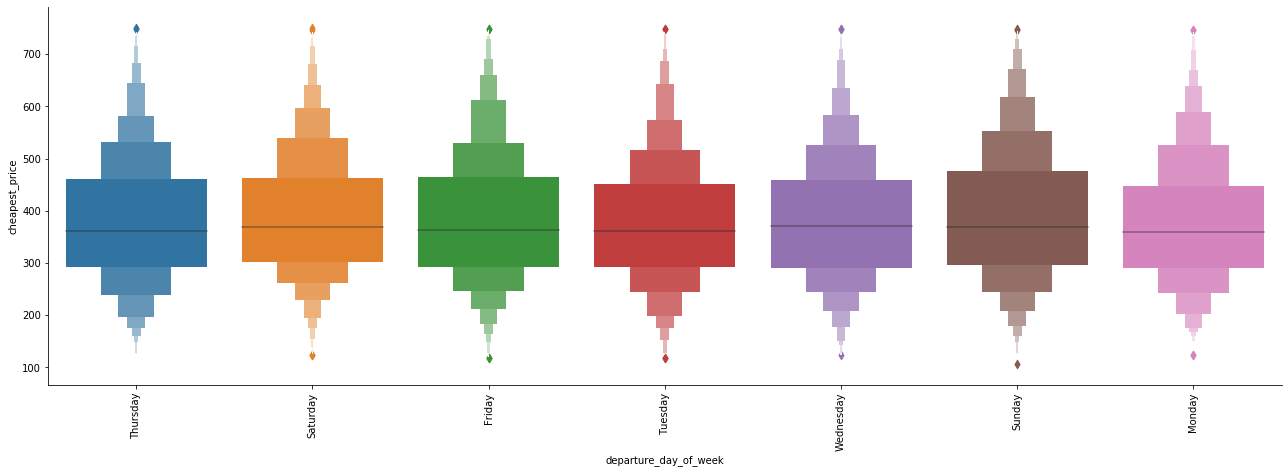

In [104]:
plot = sns.catplot(y = "cheapest_price", x = "departure_day_of_week", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)
plot.set_xticklabels(rotation=90)

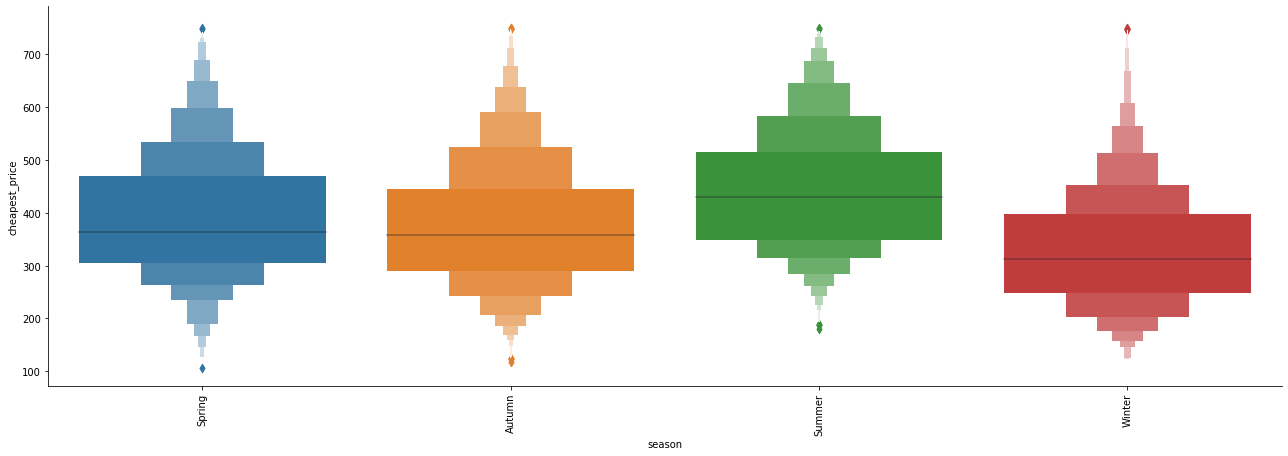

In [105]:
plot = sns.catplot(y = "cheapest_price", x = "season", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)
plot.set_xticklabels(rotation=90)

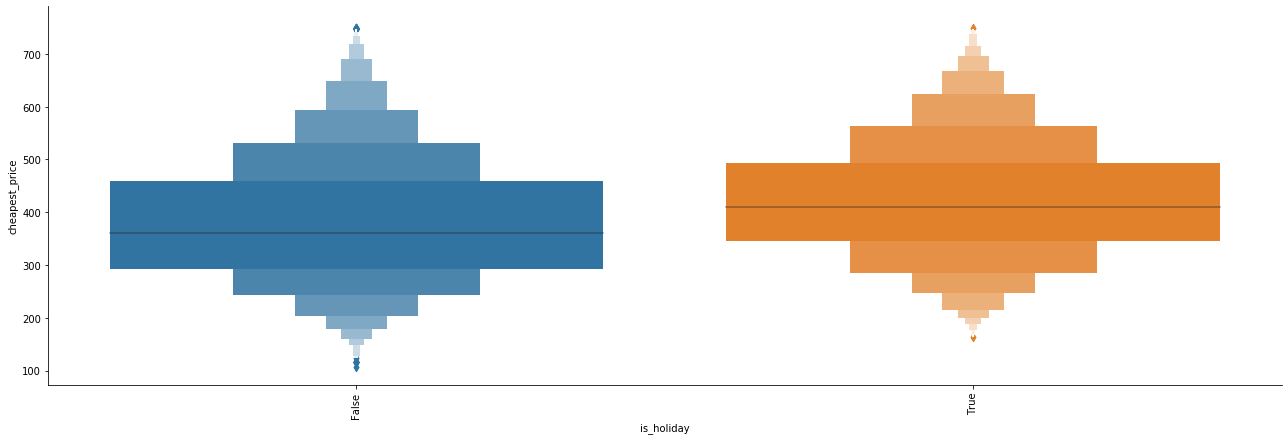

In [106]:
plot = sns.catplot(y = "cheapest_price", x = "is_holiday", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)
plot.set_xticklabels(rotation=90)

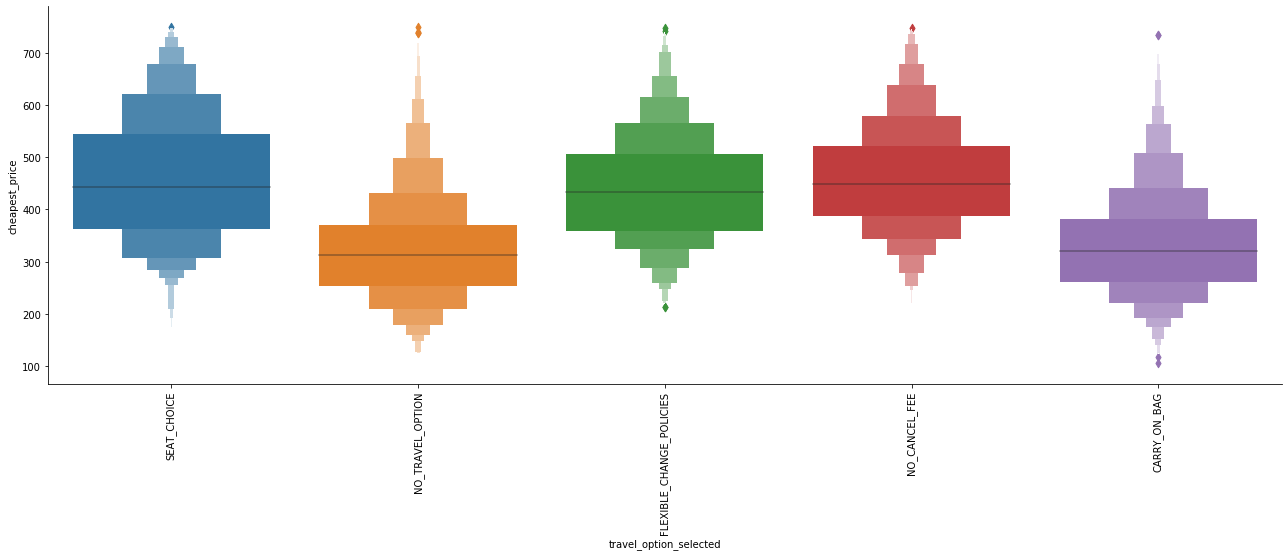

In [107]:
plot = sns.catplot(y = "cheapest_price", x = "travel_option_selected", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)
plot.set_xticklabels(rotation=90)


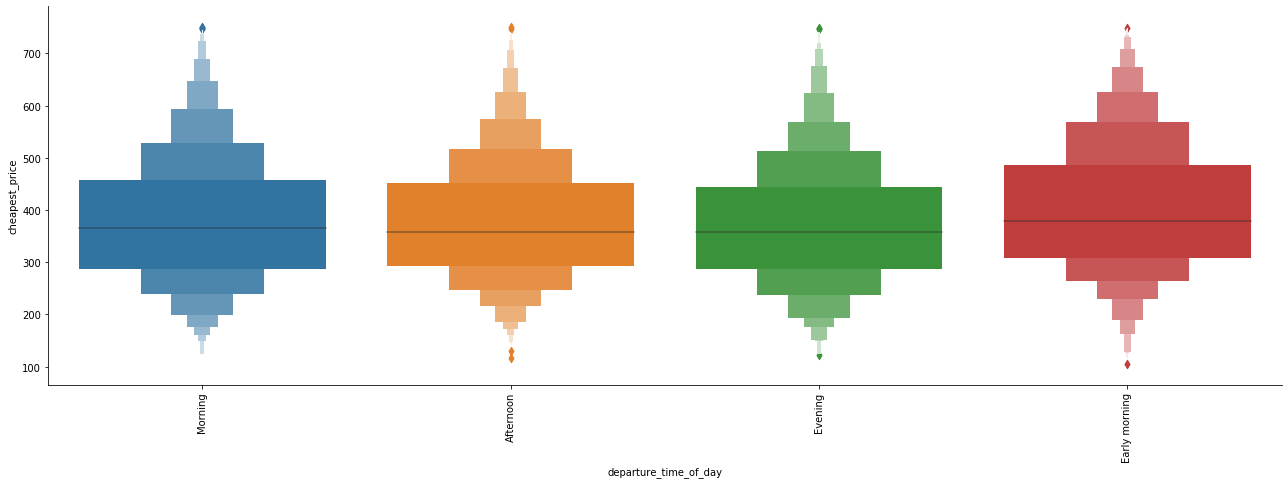

In [108]:
plot = sns.catplot(y = "cheapest_price", x = "departure_time_of_day", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)
plot.set_xticklabels(rotation=90)


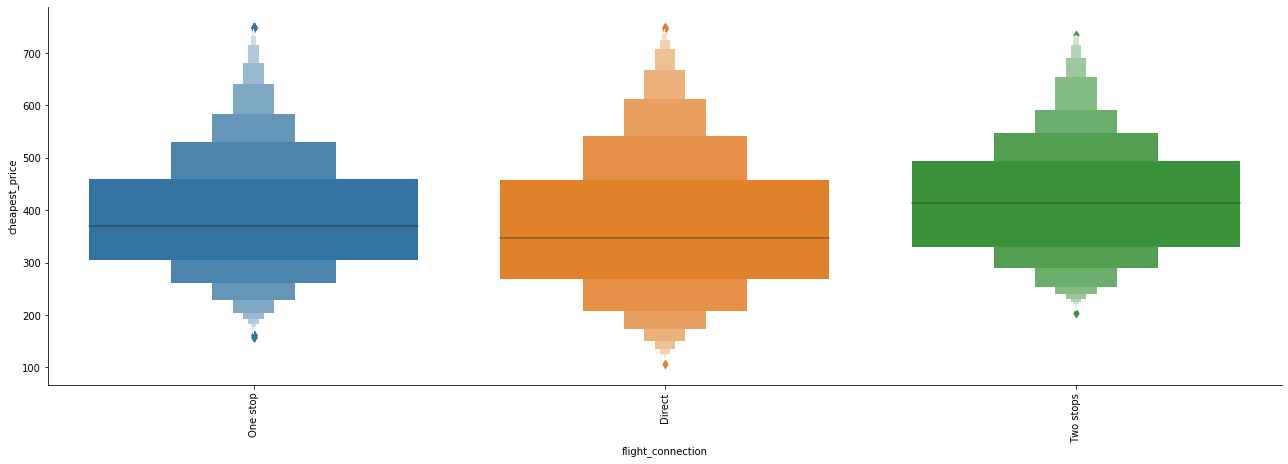

In [109]:
plot = sns.catplot(y = "cheapest_price", x = "flight_connection", data = df.sort_values("cheapest_price", ascending = False), kind="boxen", height = 6, aspect = 3)
plot.set_xticklabels(rotation=90)

# Converting all columns to boolean columns

All columns that have string values need to be converted into boolean columns. For example, there are 15+ different airlines in the 'airline' column. Each airline will then be its own column and receive the value of 0 or 1. The following block will do this for all columns except for the 'cheapest_price' and 'flight_duration'

In [110]:
def convert_columns_to_boolean_columns(df):
    for column_name, data_type in df.dtypes.items():
        if column_name != 'flight_duration' and column_name != 'cheapest_price':
            boolean_cols = pd.get_dummies(df[column_name], prefix=column_name, prefix_sep='_')
            df = pd.concat([df, boolean_cols], axis=1)
            df = df.drop(column_name, axis=1)
    return df
df = convert_columns_to_boolean_columns(df)

# Machine Learning
In this block, we will create four different models with three different dataframes.
1. df - The first dataframe contains the flight prices and durations which are represented in numeric values. Here we're    trying to solve a regression problem.

2. df2 - In the second dataframe, we converted the flight prices to 5 different categories. Doing so, we created a different problem, a classification problem. Doing this improved the accuracy of our model.

3. df3 - In the third dataframe we categorized the flight durations in addition to the flight prices categorization.

In each model we will calculate the following:
    1. MSE - calculated by: MSE = (1/n) * Σ(y_actual - y_predicted)^2
    2. The model's accuracy

In [126]:
def train_test_test_for_df(df):
    # Split the data into features (X) and target (y)
    X = df.drop('cheapest_price', axis=1)
    y = df['cheapest_price']

    # Split the data into training and testing sets
    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_random_forest_model(df):
    X = df.drop('cheapest_price', axis=1)
    X_train, X_test, y_train, y_test = train_test_test_for_df(df)

    #creating and traingthe Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed
    model.fit(X_train, y_train)

    #model evaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Random Forest MSE:", mse)
    print("Random Forest Accuracy: {}".format(model.score(X_test,y_test)))
    #feature importance
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values('Importance', ascending=False)
    top_n = 5  # Define the number of top features to display
    print(feature_importances.head(top_n))


In [133]:
def create_ranges(a, b, num_of_ranges):
    return [int(element) for element in np.linspace(a - 1, b + 1, num=num_of_ranges+1)]

def convert_price_to_categories_in_dataframe(df):
    df = df.copy()
    price_ranges = create_ranges(MIN_PRICE, MAX_PRICE, 4)
    categories = [i + 1 for i in range(len(price_ranges) - 1)]

    # Apply pd.cut() to create the categorical column
    df['cheapest_price'] = pd.cut(df['cheapest_price'], bins=price_ranges, labels=categories, right=False)
    return df

def convert_flights_duration_to_categories(df):
    df = df.copy()
    bin_labels = create_ranges(1, 10, 5)
    df['flight_duration'] = pd.cut(df['flight_duration'], bins=len(bin_labels), labels=bin_labels, right=False)
    return df

df2 = convert_price_to_categories_in_dataframe(df)
df3 = convert_flights_duration_to_categories(df2)

DATA_FRAMES = {"original": df, "Data frame with cheapest price categorized" : df2, "Data frame with cheapest price and flight duration categorized" : df3}
def train_model_with_all_dataframes(model_func, dataframes=DATA_FRAMES):
    for name, dataframe in dataframes.items():
        print(name)
        model_func(dataframe)
        print("\n")


In [129]:
train_model_with_all_dataframes(train_random_forest_model)


original
Random Forest MSE: 3859.667286671666
Random Forest Accuracy: 0.7592575157110537
                                    Feature  Importance
44  travel_option_selected_NO_TRAVEL_OPTION    0.138558
41      travel_option_selected_CARRY_ON_BAG    0.116864
0                           flight_duration    0.101898
37                            season_Summer    0.074333
38                            season_Winter    0.054377


Data frame with cheapest price categorized
Random Forest MSE: 0.21739010000555456
Random Forest Accuracy: 0.6715644356829963
                                    Feature  Importance
44  travel_option_selected_NO_TRAVEL_OPTION    0.124119
41      travel_option_selected_CARRY_ON_BAG    0.106283
0                           flight_duration    0.104381
38                            season_Winter    0.062298
37                            season_Summer    0.051682


Data frame with cheapest price and flight duration categorized
Random Forest MSE: 0.21700252490225047
Random F

In [77]:
def train_multinomial_naive_bayes_model(df):
    X_train, X_test, y_train, y_test = train_test_test_for_df(df)

    # Train the Multinomial Naive Bayes model
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print("Multinomial Naive Bayes MSE:", mse)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Multinomial Naive Bayes Accuracy:", accuracy)
train_model_with_all_dataframes(train_multinomial_naive_bayes_model)

original
Multinomial Naive Bayes MSE: 12543.83302919708
Multinomial Naive Bayes Accuracy: 0.07162408759124088


Data frame with cheapest price categorized
Multinomial Naive Bayes MSE: 0.44844890510948904
Multinomial Naive Bayes Accuracy: 0.6373175182481752


Data frame with cheapest price and flight duration categorized
Multinomial Naive Bayes MSE: 0.4393248175182482
Multinomial Naive Bayes Accuracy: 0.6427919708029197




In [78]:
def train_neural_network_model(df):
    X_train, X_test, y_train, y_test = train_test_test_for_df(df)

    # Train the Neural Network model
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500, learning_rate_init=0.001)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print("Neural Network MSE:", mse)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Neural Network Accuracy:", accuracy)

# Running on df (original) is very slow with 100% cpu
filtered_dict = {key: value for key, value in DATA_FRAMES.items() if value is not df}
train_model_with_all_dataframes(train_neural_network_model, filtered_dict)

Data frame with cheapest price categorized
Neural Network MSE: 0.3261861313868613
Neural Network Accuracy: 0.7217153284671532


Data frame with cheapest price and flight duration categorized
Neural Network MSE: 0.32983576642335766
Neural Network Accuracy: 0.7162408759124088




In [79]:
def train_logistic_regression(df):
    X_train, X_test, y_train, y_test = train_test_test_for_df(df)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print("Logistic Regression MSE:", mse)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Logistic Regression Accuracy:", accuracy)
    
# Running on df (original) is very slow with 100% cpu
filtered_dict = {key: value for key, value in DATA_FRAMES.items() if value is not df}

train_model_with_all_dataframes(train_logistic_regression, filtered_dict)

Data frame with cheapest price categorized
Logistic Regression MSE: 0.7153284671532847
Logistic Regression Accuracy: 0.4927007299270073


Data frame with cheapest price and flight duration categorized
Logistic Regression MSE: 0.7299270072992701
Logistic Regression Accuracy: 0.4904197080291971




In [80]:
def train_knn_model(df):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_test_for_df(df)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the KNN model
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate the mean squared error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print("KNN MSE:", mse)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("KNN Accuracy:", accuracy)
train_model_with_all_dataframes(train_knn_model)

original
KNN MSE: 14220.787864963504
KNN Accuracy: 0.08302919708029197


Data frame with cheapest price categorized
KNN MSE: 0.40191605839416056
KNN Accuracy: 0.6902372262773723


Data frame with cheapest price and flight duration categorized
KNN MSE: 0.40191605839416056
KNN Accuracy: 0.6902372262773723




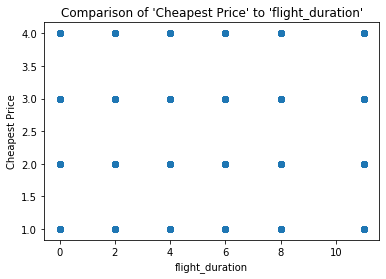